<h1 align="center"> Relationship of personality traits with the probability of being employed in Poland</h1>

<h5 align="center">Natalia Graczyk</h5>

The analysis below is part of my master's thesis defended at University of Warsaw in June 2022.

## Abstract

The current challenges of the labour market require a thorough analysis of factors related to the probability of employment of individuals. This paper presents the most important theories related to the labour market, such as the Search and Matching Theory, the Human Capital Theory and the Statistical Discrimination Theory. With reference to the psychological aspect of this paper, the most well-known theory on personality traits of individuals, which is The Big Five Theory, was presented as well.
 
In the empirical part of this paper, based on the data from the PIAAC and post-PIAAC studies, logit model was estimated, aiming at examinating the relationship of personality traits with the probability of employment in Poland. The results showed that differences in respondents' personalities were related to the probability of employment.

In [918]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
import warnings
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import seaborn as sns
import plotly.express as px
import textwrap
from imblearn.over_sampling import SMOTE
import statsmodels.api as sm


In [747]:
with warnings.catch_warnings():
     warnings.filterwarnings('ignore')

## Data

The analysis was performed based on individual-derived data from the PIAAC study (Programme for the International Assessment of Adult Competencies) for Poland, as well as its national follow-up (post-PIAAC), in which additional information was collected from people participating in the first edition of the study. The PIAAC survey was conducted among randomly selected individuals aged 16-65 years living in Poland during the period of data collection for the survey, i.e. 2011-2012. The postPIAAC survey population consisted of participants in the first edition of the survey (PIAAC), living in Poland between October 2014 and February 2015. 

This particular data was chosen because it is the only study on the situation of Poles in the labor market that provides not only information about the cognitive skills of respondents, but also their personality traits.

The relationship of personality traits with the probability of employment will be estimated using logistic regression model in which the employment status during post-PIAAC study is the dependent variable and takes the values of 1 in case of being employed and 0 in case of being unemployed or professionally inactive during that period. It was decided to use the logit model because for the purposes of this study, it was important to compare the model with the results of other studies conducted in other countries.

In [817]:
MY_PATH = os.path.join('C:', os.sep)

def fetch_data(path = MY_PATH):
    csv_path = os.path.join(path, "piaac_postpiaac_data.csv")
    return pd.read_csv(csv_path)

In [818]:
data = fetch_data()

In [786]:
data.shape

(4954, 11)

The dataset includes 4954 rows and 11 columns.

In [819]:
data.head(5)

,conscientiousness,extroversion,agreeableness,openness,neuroticism,age,gender,education,education_field,training,employment_status
0,5.666666,3.333333,6.000000,3.666667,4.666666,23,Male,upper secondary or post-secondary education,general programmes,training in the 12 months prior to the postPIAAC,employed
1,7.000000,4.000000,4.000000,4.000000,4.000000,33,Male,basic vocational education,"engineering, manufacturing and construction",no training in the 12 months prior to the study,employed
2,5.000000,2.000000,3.333333,4.333334,3.666667,19,Male,upper secondary or post-secondary education,no education,training in the 12 months prior to the postPIAAC,employed
3,6.000000,2.666667,4.000000,3.333333,3.666667,20,Female,tertiary education,"science, mathematics and computing",no training in the 12 months prior to the study,unemployed
4,7.000000,5.000000,6.333334,5.333334,2.333333,19,Male,upper secondary or post-secondary education,no education,no training in the 12 months prior to the study,employed


The main explanatory variables on which this study focuses concern personality traits.

The Big Five personality variables were measured in the postPIAAC study using the BFI-S Abbreviated Personality Inventory. This questionnaire contains 15 statements, (three statements for each personality dimension), which are answered on a 7-point Likert scale (from 1 - 'completely disagree' to 7 - 'completely agree'). The final scores for each dimension were calculated as the average of the three statements.

In addition to personality traits variables, control variables were also included in the analysis. Based on the literature review, it was decided to include variables controlling for demographic characteristics (age, gender) and human capital variables (level of education, branch of  education and training received). 

In [820]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4954 entries, 0 to 4953
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   conscientiousness  4718 non-null   float64
 1   extroversion       4681 non-null   float64
 2   agreeableness      4707 non-null   float64
 3   openness           4650 non-null   float64
 4   neuroticism        4692 non-null   float64
 5   age                4954 non-null   int64  
 6   gender             4954 non-null   object 
 7   education          4954 non-null   object 
 8   education_field    4954 non-null   object 
 9   training           4954 non-null   object 
 10  employment_status  4954 non-null   object 
dtypes: float64(5), int64(1), object(5)
memory usage: 425.9+ KB


## Exploratory Data Analysis

### Univariate analysis

Firstly, let's delve into summary statistics of the data:

In [789]:
data.describe()

,conscientiousness,extroversion,agreeableness,openness,neuroticism,age
count,4718.000000,4681.000000,4707.000000,4650.000000,4692.000000,4954.000000
mean,5.718737,4.083458,5.076553,5.043513,4.114379,31.563181
std,0.993417,1.096253,1.093071,1.108594,1.275235,14.054196
min,1.000000,1.000000,1.000000,1.000000,0.666667,16.000000
25%,5.000000,3.333333,4.333334,4.333334,3.333333,21.000000
50%,5.666666,4.000000,5.000000,5.000000,4.000000,25.000000
75%,6.666666,5.000000,6.000000,6.000000,5.000000,41.000000
max,7.000000,7.000000,7.000000,7.000000,7.000000,65.000000


Personality traits were measured based on 7-point Linert scale, thus it's not possible to have a minimum value of 0.7 in the neuroticism column.

In [821]:
data[data.neuroticism < 1]

,conscientiousness,extroversion,agreeableness,openness,neuroticism,age,gender,education,education_field,training,employment_status
1584,NaN,5.0,NaN,3.0,0.666667,24,Male,primary or lower secondary education,no education,no training in the 12 months prior to the study,unemployed


In [822]:
neuroticism_outlier = data[data.neuroticism < 1]
data.drop(neuroticism_outlier.index, inplace = True)


#### Personality Traits

Let's see what's the distribution of the personality traits variables.

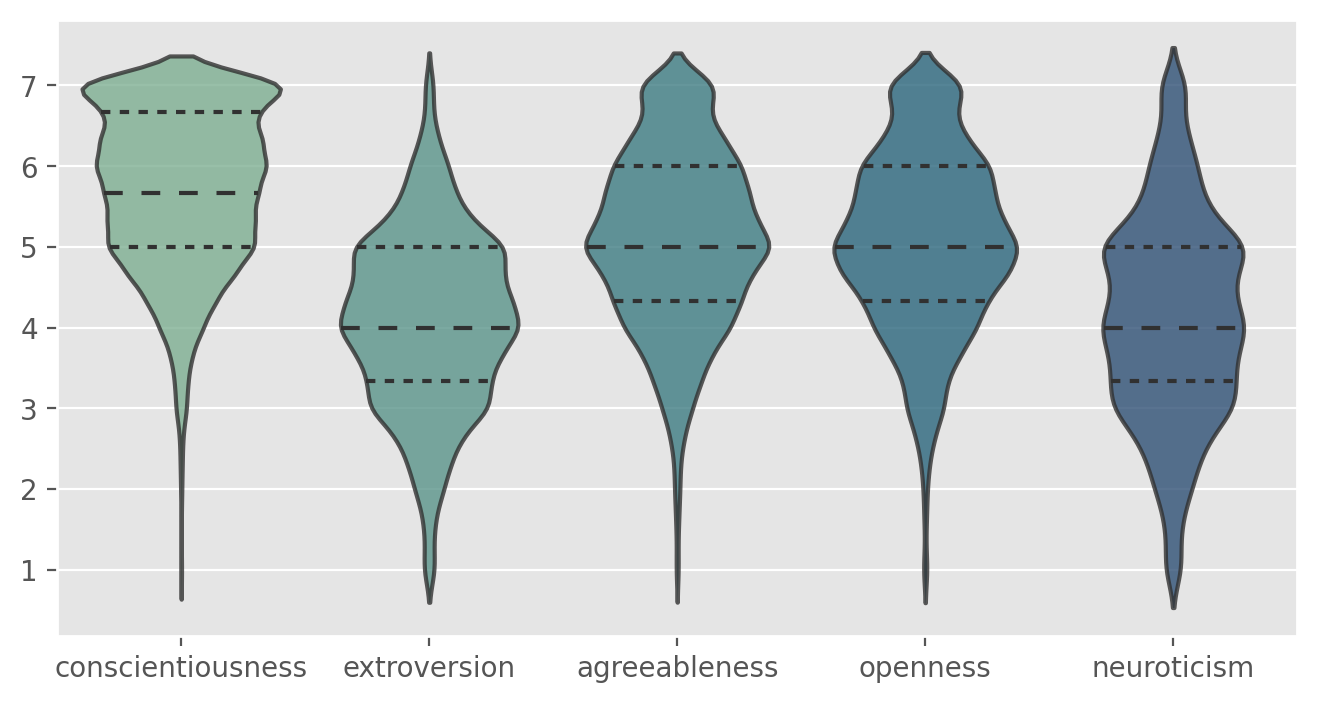

In [756]:
plt.figure(figsize=(8,4), dpi=200)

ax = sns.violinplot(
       data = data[['conscientiousness', 'extroversion', 'agreeableness', 'openness',
       'neuroticism']],
       palette = "crest", 
       inner = "quartile")

plt.setp(ax.collections, alpha=.8)

plt.show()


The results of the personality test on the larger sample should form a normal distribution. As can be seen from the graphs, the probability density distributions for `extraversion` and `neuroticism` are close to a normal distribution, while for the traits `conscientiousness`, `agreeableness` and `openness`, a left skewness of the distributions was observed. 
In the case of `conscientiousness`, the leftward skewness is confirmed in the literature and is due to the fact that respondents often tend to give answers that are more socially desirable in relation to this trait.  



#### Age

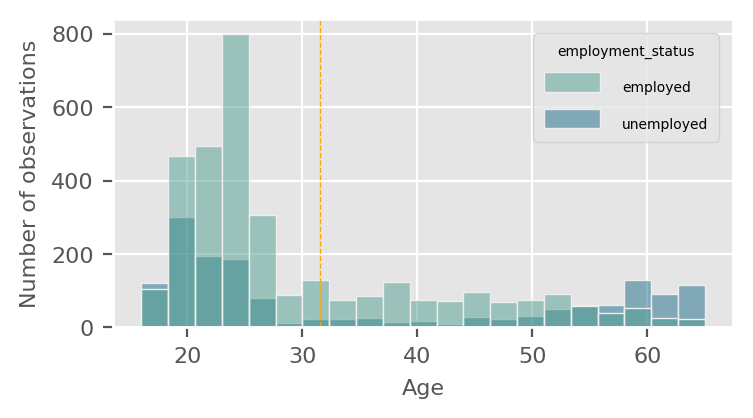

In [660]:
plt.figure(figsize=(4,2), dpi=200)
plt.style.use('ggplot')

ax = sns.histplot(
       data = data,
       x = "age",
       hue = "employment_status",
       palette = "crest")

ax.axvline(x=data.age.mean(),
            color='orange',
            linestyle = '--',
            linewidth = 0.5)

ax.set_xlabel("Age", fontsize = 8)
ax.set_ylabel("Number of observations", fontsize = 8)

plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)
plt.setp(ax.get_legend().get_texts(), fontsize='5') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='5') # for legend title

plt.show()

The average age was 31. It should be noted that the Polish study chose to over-represent young people aged 19-26, the purpose of which was to enable a detailed analysis between young people's competences and educational and professional pathways.

#### Gender

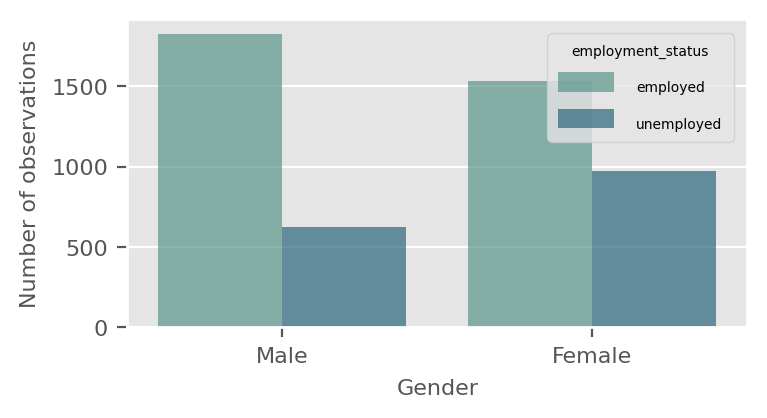

In [661]:
plt.figure(figsize=(4,2), dpi=200)
plt.style.use('ggplot')

ax = sns.countplot(
       data = data,
       x = "gender",
       hue = "employment_status",
       palette = "crest", 
       alpha = 0.7)

ax.set_xlabel("Gender", fontsize = 8)
ax.set_ylabel("Number of observations", fontsize = 8)

plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)
plt.setp(ax.get_legend().get_texts(), fontsize='5') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='5') # for legend title

plt.show()

#### Education

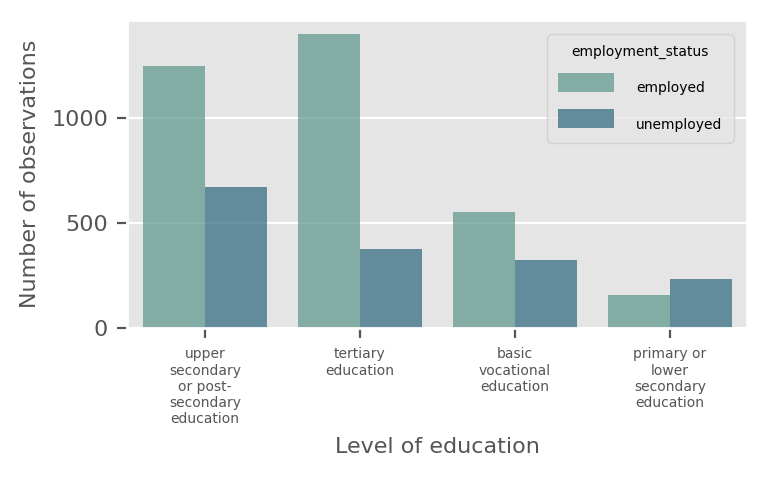

In [670]:
plt.figure(figsize=(4,2), dpi=200)
plt.style.use('ggplot')

ax = sns.countplot(
       data = data,
       x = "education",
       hue = "employment_status",
       order = data["education"].value_counts().index,
       palette = "crest", 
       alpha = 0.7)

ax.set_xlabel("Level of education", fontsize = 8)
ax.set_ylabel("Number of observations", fontsize = 8)


# https://medium.com/dunder-data/automatically-wrap-graph-labels-in-matplotlib-and-seaborn-a48740bc9ce
def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=0)
    
wrap_labels(ax, 10)
ax.figure

plt.xticks(fontsize = 5)
plt.yticks(fontsize = 8)
plt.setp(ax.get_legend().get_texts(), fontsize='5') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='5') # for legend title

plt.show()

The majority of respondents had a secondary or post-secondary education or a tertiary education - bachelor's or master's degree. 

#### Field of education

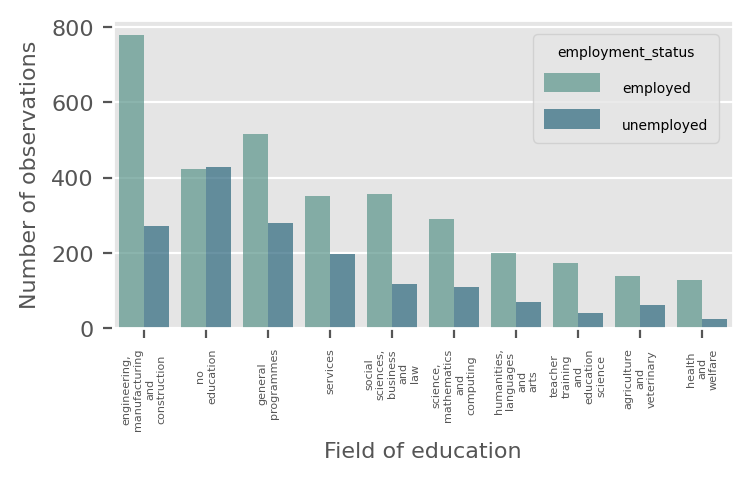

In [671]:
plt.figure(figsize=(4,2), dpi=200)
plt.style.use('ggplot')

ax = sns.countplot(
       data = data,
       x = "education_field",
        hue = "employment_status",
       order = data["education_field"].value_counts().index,
       palette = "crest", 
       alpha = 0.7)

ax.set_xlabel("Field of education", fontsize = 8)
ax.set_ylabel("Number of observations", fontsize = 8)

# https://medium.com/dunder-data/automatically-wrap-graph-labels-in-matplotlib-and-seaborn-a48740bc9ce
def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=0)
    
wrap_labels(ax, 5)
ax.figure

plt.xticks(fontsize = 4, rotation = 90)
plt.yticks(fontsize = 8)
plt.setp(ax.get_legend().get_texts(), fontsize='5') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='5') # for legend title

plt.show()

#### Trainings

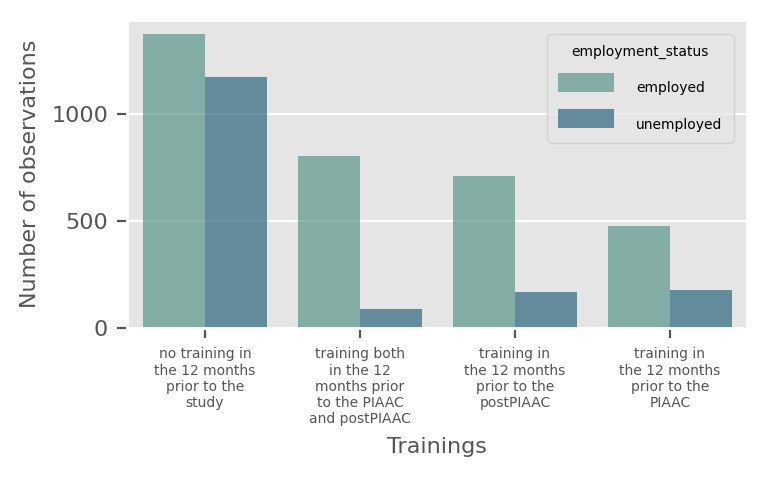

In [672]:
plt.figure(figsize=(4,2), dpi=200)
plt.style.use('ggplot')

ax = sns.countplot(
       data = data,
       x = "training",
       hue = "employment_status",
       order = data["training"].value_counts().index,
       palette = "crest", 
       alpha = 0.7)

ax.set_xlabel("Trainings", fontsize = 8)
ax.set_ylabel("Number of observations", fontsize = 8)

plt.xticks(fontsize = 5)
plt.yticks(fontsize = 8)

# https://medium.com/dunder-data/automatically-wrap-graph-labels-in-matplotlib-and-seaborn-a48740bc9ce
def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=0)
    
wrap_labels(ax, 14)
ax.figure

plt.xticks(fontsize = 5)
plt.yticks(fontsize = 8)
plt.setp(ax.get_legend().get_texts(), fontsize='5') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='5') # for legend title

plt.show()

The majority of respondents had not received any training in the two years preceding the PIAAC and postPIAAC survey. 

#### Employment status during postPIAAC study

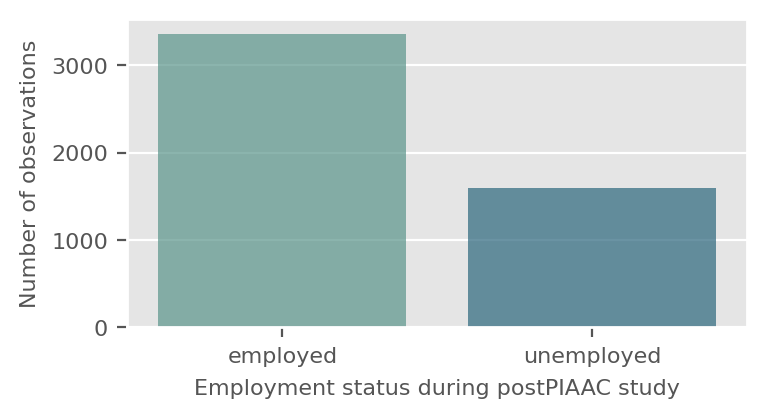

In [666]:
plt.figure(figsize=(4,2), dpi=200)
plt.style.use('ggplot')

ax = sns.countplot(
       data = data,
       x = "employment_status",
       palette = "crest", 
       alpha = 0.7)

ax.set_xlabel("Employment status during postPIAAC study", fontsize = 8)
ax.set_ylabel("Number of observations", fontsize = 8)

plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)

plt.show()

From the above chart we can observe that there is a class imbalance, which will be addressed at a later stage of this analysis.

### Bivariate analysis

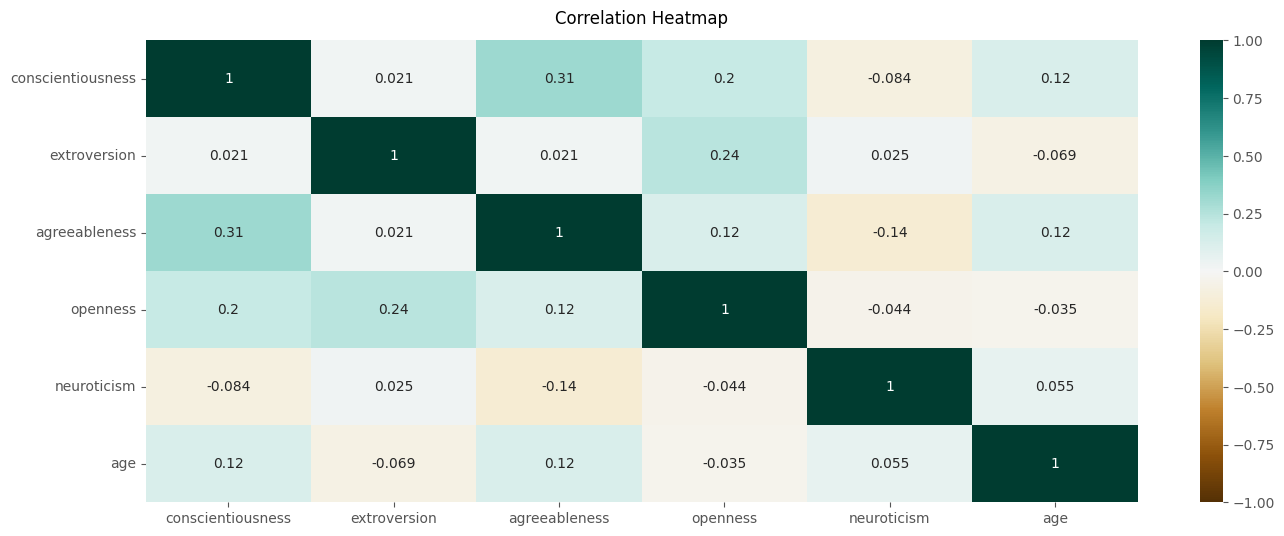

In [668]:
plt.figure(figsize=(16, 6))

heatmap = sns.heatmap(data.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')

heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

plt.show()

Relatively strong correlations were observed between variables representing human capital - more specifically between `education` and `trained`, which may indicate that better educated people were more likely to have participated in trainings. 
As for the outcome variable, `trained` was the most strongly correlated variable. 

Among the Big Five characteristics, the variables `conscientiousness` and `agreeableness`, `conscientiousness` and `openness`, as well as `extraversion` and `openness` showed the strongest correlation with each other. 
In case of the outcome variable, the strongest correlation among all personality traits was observed for `neuroticism`. `Openness`, on the other hand, had the highest correlation coefficient among the traits with the variable `education` and `trained`. 

The other correlations were rather average or weak. 

Furthermore, it should be emphasised here that both the Big Five personality traits and cognitive skills were measured in the postPIAAC study, therefore at the same point in time for all observations. This means that the young people taking part in the study may still have been in the midst of their educational attainment, while the older people may have been many years past it. 

## Data cleaning and feature engineering


During the feature engineering process, label encoding as well as one-hot encoding will be performed. In addition, duplicates will be removed and missing values will be replaced using the appropriate imputation method.

The attributes `gender`, `education`, `education_field`, `training` and `employment_status` are object data type i.e. categorical type.

### Label encoding

For the `education`, `gender` and `employment_status` variables the label encoding will be applied:

Gender

In [823]:
enc = OrdinalEncoder()

data[['gender']] = enc.fit_transform(data[['gender']])

Education

In [824]:
data.education.unique()

array(['upper secondary or post-secondary education',
       'basic vocational education', 'tertiary education',
       'primary or lower secondary education'], dtype=object)

In [825]:
education_levels = ['primary or lower secondary education',
                    'basic vocational education',
                    'upper secondary or post-secondary education',
                    'tertiary education']

edu_enc = OrdinalEncoder(categories = [education_levels])

data["education"] = edu_enc.fit_transform(data[["education"]])

Employment status

In [826]:
emp_statuses = ['unemployed',
                'employed']

emp_enc = OrdinalEncoder(categories = [emp_statuses])

data["employment_status"] = emp_enc.fit_transform(data[["employment_status"]])

In [827]:
data.head(2)

,conscientiousness,extroversion,agreeableness,openness,neuroticism,age,gender,education,education_field,training,employment_status
0,5.666666,3.333333,6.0,3.666667,4.666666,23,1.0,1.0,general programmes,training in the 12 months prior to the postPIAAC,1.0
1,7.000000,4.000000,4.0,4.000000,4.000000,33,1.0,2.0,"engineering, manufacturing and construction",no training in the 12 months prior to the study,1.0


### One-Hot Encoding

As the `education_field` and `training` variable contains more categories, One Hot Encoding will be used in this case.

In [828]:
data = pd.get_dummies(data, columns = ["education_field", "training"])

In [829]:
data.head(2)

,conscientiousness,extroversion,agreeableness,openness,neuroticism,age,gender,education,employment_status,education_field_agriculture and veterinary,...,"education_field_humanities, languages and arts",education_field_no education,"education_field_science, mathematics and computing",education_field_services,"education_field_social sciences, business and law",education_field_teacher training and education science,training_no training in the 12 months prior to the study,training_training both in the 12 months prior to the PIAAC and postPIAAC,training_training in the 12 months prior to the PIAAC,training_training in the 12 months prior to the postPIAAC
0,5.666666,3.333333,6.0,3.666667,4.666666,23,1.0,1.0,1.0,0,...,0,0,0,0,0,0,0,0,0,1
1,7.000000,4.000000,4.0,4.000000,4.000000,33,1.0,2.0,1.0,0,...,0,0,0,0,0,0,1,0,0,0


### Data cleaning

As `age` can have a non-linear relationship on the independent variable, it was decided to create an `age_squared` variable to explore this.

In [830]:
age_squared = data.age**2

data.insert(6, 'age_squared', age_squared)

In [831]:
personality_cols = ['conscientiousness', 'extroversion', 'agreeableness', 'openness',
                    'neuroticism']

data[personality_cols] = data[personality_cols].round(decimals = 1)

Logistic regression cannot handle missing values well. Let's see in which columns they occur:

In [832]:
data.isna().sum()

conscientiousness                                                           235
extroversion                                                                273
agreeableness                                                               246
openness                                                                    304
neuroticism                                                                 262
age                                                                           0
age_squared                                                                   0
gender                                                                        0
education                                                                     0
employment_status                                                             0
education_field_agriculture and veterinary                                    0
education_field_engineering, manufacturing and construction                   0
education_field_general programmes      

As the analyzed sample is relatively small and the missing data are present for variables related to the personality traits, in order not to lose too much information, it was decided to use the imputation method for replacing missing data. 

In [833]:
imputer = SimpleImputer(strategy="median")
imputer.fit(data)

X = imputer.transform(data)
data = pd.DataFrame(X, columns = data.columns, index = data.index)

In [895]:
data.isna().values.any()

False

Now let's see whether we have any duplicates in the dataset:

In [835]:
data.duplicated().sum()

10

In [836]:
data.drop_duplicates(inplace = True)

## Feature scaling

At this stage of the analysis, we'll standardize the data in order to prevent features with wider ranges from dominating the distance metric.


In [807]:
data.head(2)

,conscientiousness,extroversion,agreeableness,openness,neuroticism,age,age_squared,gender,education,employment_status,...,"education_field_humanities, languages and arts",education_field_no education,"education_field_science, mathematics and computing",education_field_services,"education_field_social sciences, business and law",education_field_teacher training and education science,training_no training in the 12 months prior to the study,training_training both in the 12 months prior to the PIAAC and postPIAAC,training_training in the 12 months prior to the PIAAC,training_training in the 12 months prior to the postPIAAC
0,5.7,3.3,6.0,3.7,4.7,23.0,529.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,7.0,4.0,4.0,4.0,4.0,33.0,1089.0,1.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Let's standarize all the continuous variables:

In [808]:
cont_cols = ['conscientiousness', 'extroversion', 'agreeableness', 'openness',
       'neuroticism', 'age', 'age_squared']

data_num = data[cont_cols]

In [810]:
scale=StandardScaler()

standarized_data = scale.fit_transform(data_num)
standarized_df = pd.DataFrame(standarized_data, columns = data_num.columns)

In [812]:
standarized_df.head(2)

,conscientiousness,extroversion,agreeableness,openness,neuroticism,age,age_squared
0,-0.019213,-0.729594,0.868589,-1.248687,0.475812,-0.609248,-0.604143
1,1.318356,-0.073649,-1.005210,-0.969610,-0.087758,0.102525,-0.094926


In [848]:
for col in cont_cols:
    data[col] = standarized_df[col].values

## Handling imbalanced data using SMOTE

As we have seen above on the graph, the outcome variable in this study is imbalanced - there's much more people who were employed during postPIAAC study than unemployed. To solve this inconvenience we will use SMOTE algorithm (synthetic minority oversampling technique) and perform oversampling. SMOTE synthesises new minority instances between existing minority instances.

In [865]:
X = data.loc[:, data.columns != 'employment_status']
y = data.loc[:, data.columns == 'employment_status']

print("The shape of X: ", X.shape)
print("The shape of y: ", y.shape)

The shape of X:  (4943, 23)
The shape of y:  (4943, 1)


In [914]:

print(f"Before OverSampling, counts of label '1' and '0': \n\n{y.value_counts()}\n")

oversample = SMOTE()
X_res, y_res = oversample.fit_resample(X, y)
  
print(f"After OverSampling, counts of label '1' and '0': \n\n{y_res.value_counts()}\n")


Before OverSampling, counts of label '1' and '0': 

employment_status
1.0                  3350
0.0                  1593
dtype: int64

After OverSampling, counts of label '1' and '0': 

employment_status
0.0                  3350
1.0                  3350
dtype: int64



## Building Logistic Regression Model

In [925]:
logit_model=sm.Logit(y_res,X_res)

result=logit_model.fit()

print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.534356
         Iterations 6
                                                             Results: Logit
Model:                                       Logit                                    Pseudo R-squared:                        0.229    
Dependent Variable:                          employment_status                        AIC:                                     7204.3705
Date:                                        2022-08-31 11:53                         BIC:                                     7354.1875
No. Observations:                            6700                                     Log-Likelihood:                          -3580.2  
Df Model:                                    21                                       LL-Null:                                 -4644.1  
Df Residuals:                                6678                                     LLR p-value:                             0.0000   
